# Concatenating an LSTM and Densely-connected Neural network

In situations where time-series features and unit-level features are required to make a prediction, both data formats can be joined in a neural network architecture. For instance, say you want to predict someone's lifetime value which takes into account their spending pattern (time-series) as well as demographic information (unit-level). This workbook simulates a scenario where both data points are required to make a binary prediction.

To validate this, we will build:
- A simple dense network using demographics alone
- An LSTM network using the sequence data
- A concatenation of both networks above

We will use the predictive accuracy to assess network

In [1]:
import tensorflow
from tensorflow.compat.v1.keras.backend import set_session
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tensorflow.compat.v1.Session(config=config)
set_session(sess)

In [2]:
## Bring in libraries
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input

## wuz happening
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Activation, Dropout, Dense

import pandas as pd
import os as os
import numpy as np
import re
import pydot

In [3]:
os.chdir("C:/Users/abbal/Documents/Py - LSTM Learning")
RawData = pd.read_csv("Sequence Simulator.csv")

This datafile contains three demographic metrics: Male, Old, Minority
And 80-step time series. Theoretically, this network could fit multiple time-series inputs,
but for simplicity, we'll only use one.

In [4]:
## Set up my X and Y
X = RawData.loc[:, RawData.columns != 'Outcome']
Y = RawData['Outcome']

In [5]:
## will use encoder to make it future-proof, but not necessary
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

Y = label_encoder.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [6]:
## Will have two sets of Xs:
## 1 - Binary metrics
## 2 - Time Series (sequence)

X_train_1 = X_train[X_train.columns[[0,1,2]]]
X_test_1 =  X_test[X_test.columns[[0,1,2]]]
X_train_1 = np.asarray(X_train_1)

X_train_2 = X_train[X_train.columns[range(3,83)]]
X_test_2 = X_test[X_test.columns[range(3,83)]]

X_train_2_Matrix = X_train_2.values

X_train_2_Matrix = X_train_2_Matrix.reshape(8000,80,1)


# Model 1: Dense Network with demographics only

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

model_v1 = models.Sequential()
model_v1.add(layers.Dense(3, activation='relu', input_shape=(3,)))
model_v1.add(layers.Dense(10, activation='relu'))
model_v1.add(layers.Dense(1, activation='sigmoid'))

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


In [8]:
## Compiling
from tensorflow.keras import optimizers

model_v1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [9]:
%%capture

## Run
history_v1 = model_v1.fit(X_train_1, 
                       y_train, epochs=100, 
                       batch_size=128, 
                       validation_split=0.2)

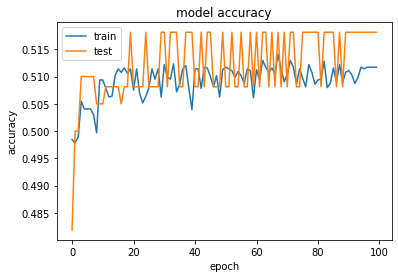

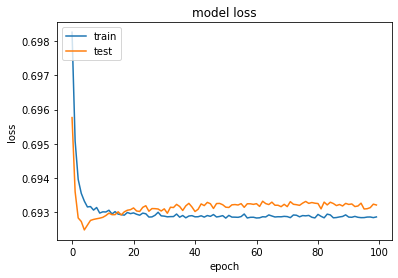

In [10]:
import matplotlib.pyplot as plt

plt.plot(history_v1.history['acc'])
plt.plot(history_v1.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The model performed extremely poorly. As expected, without the binary data, the model cannot perform better than random.

# Model 2: LSTM with sequence data only

In [11]:
model_v2 = models.Sequential()
model_v2.add(layers.LSTM(100, activation='relu', input_shape=(80,1)))
model_v2.add(layers.Dense(10, activation='relu'))
model_v2.add(layers.Dense(1, activation='sigmoid'))

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 41,821
Trainable params: 41,821
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_v2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [13]:
%%capture

## Run
history_V2 = model_v2.fit(X_train_2_Matrix, 
                       y_train, epochs=100, 
                       batch_size=128, 
                       validation_split=0.2)

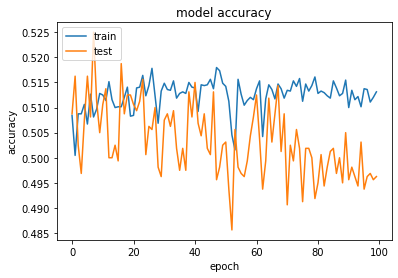

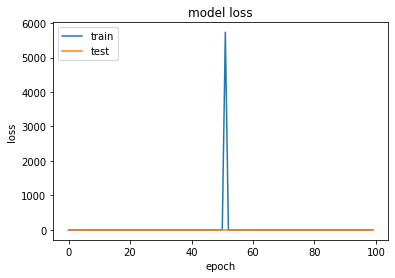

In [14]:
import matplotlib.pyplot as plt

plt.plot(history_V2.history['acc'])
plt.plot(history_V2.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_V2.history['loss'])
plt.plot(history_V2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Again, this model cannot predict better than random.

# Model 3: Concatenate LSTM and Dense network

In [15]:
## Sequence Data
input1 = Input(shape=(80,1))
Seqnc = LSTM(100)(input1)
Seqnc = Dense(100, activation='relu')(Seqnc)

## Demo Data
input2 = Input(shape=(3,))
demo = Dense(10, activation='relu')(input2)
demo = Dense(10, activation='relu')(demo)

## Concatenate
concat_layer = Concatenate()([Seqnc, demo])

## Build final Layer
hidden1 = Dense(100, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(hidden1)
model = Model(inputs=[input1, input2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100)          40800       input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 10)           40          input_2[0][0]                    
______________________________________________________________________________________________

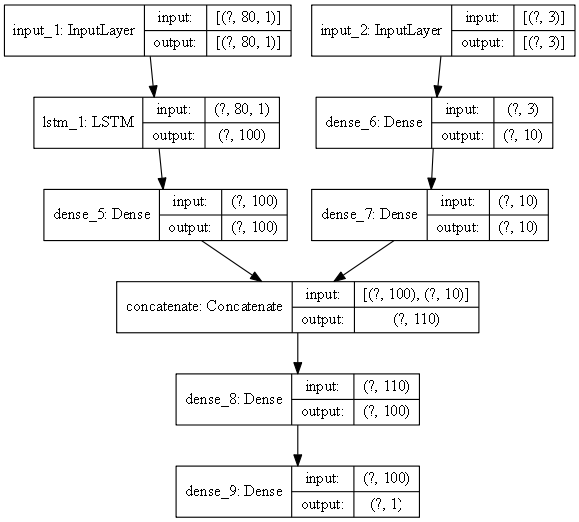

In [16]:
## Note how there are two input layers.
## Let's try a different visualization
## Note how there are two input layers
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi = 80)

In [17]:
%%capture

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

history = model.fit([X_train_2_Matrix, X_train_1], 
                    y_train, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2)

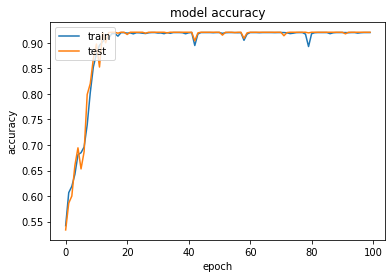

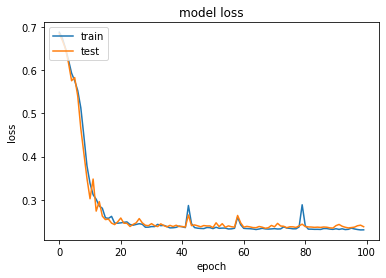

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Fantastic! Neither the Dense nor the LSTM network yielded any predictive power, but when the interaction between those two are introduced, the prediction is nearly perfect. Obviously, the simulated data was created to yield these same exact results, but these interactions exist in the real world. 

Certain sequences can look identical, but coming from separate sources, those same sequences can mean fundamentally different things.